TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'vol', 'vol10', 'vol15', 'vol30', 'vol60', 'volD10',
       'volD15', 'volD30', 'volD60', 'vpm5', 'vpm10', 'vpm15', 'vpm30',
       'vpm60', 'ToD', 'DoW', 'MO'],
      dtype='object')
TESTING FOR: 
Dr1
1566 Fitting on 195
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


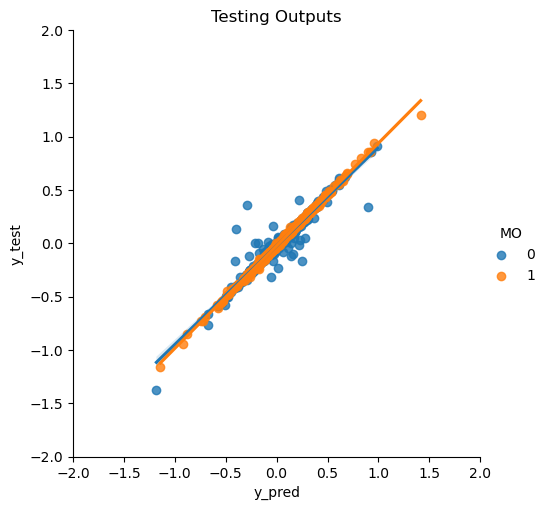

In [30]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted__6dayTest_1.csv')
dataTRAIN = pd.read_csv('catted_1.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'Dr1'
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns='FT')
data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')
data = data.drop(columns='YM_diff')
data = data.drop(columns='NQ_diff')
data = data.drop(columns='volNQdiff')
data = data.drop(columns='volYMdiff')
dataTRAIN = dataTRAIN.drop(columns='FT')
dataTRAIN = dataTRAIN.drop(columns='FT.1')
dataTRAIN = dataTRAIN.drop(columns='FT.2')
dataTRAIN = dataTRAIN.drop(columns='YM_diff')
dataTRAIN = dataTRAIN.drop(columns='NQ_diff')
dataTRAIN = dataTRAIN.drop(columns='volNQdiff')
dataTRAIN = dataTRAIN.drop(columns='volYMdiff')

#CALENDAR
#--------------------------------------
#SOLUTION------------------------------
data = data.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
dataTRAIN = dataTRAIN.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
match testFor:
    case 'Dr1':
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Dr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr1':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

XTRAIN = dataTRAIN.iloc[:, :-1].values
yTRAIN = dataTRAIN.iloc[:, -1].values

#setting data for LSTM
def reformat_lstm_data_numpy(data, time_steps=5):
    n_samples, n_features = data.shape
    # Ensure we have enough samples for the given time_steps
    reformatted_data = []
    for i in range(n_samples - time_steps + 1):
        reformatted_data.append(data[i:i + time_steps])
    return np.array(reformatted_data)

def remove_zero_mo_samples(X, y):
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    szTmp = X.shape[2]-1
    mo_column = X[:, :, szTmp]
    # Identify samples where 'MO' has no zeros across all time steps
    valid_samples = np.all(mo_column != 0, axis=1)
    # Filter both X and y to keep only valid samples
    X_filtered = X[valid_samples]
    y_filtered = y[valid_samples]
    return X_filtered, y_filtered

# Standardize the features
scaler = StandardScaler()
tmpScaleFactor = 8
scaler.fit(X[:len(X)//tmpScaleFactor])
print(len(X),'Fitting on',len(X)//tmpScaleFactor)
X = scaler.transform(X)

timeSteps = 5
X = reformat_lstm_data_numpy(X, timeSteps)
y = y[:-timeSteps+1]
X, y = remove_zero_mo_samples(X, y)


def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('LSTM_Dr1.keras')
    loaded_model.compile(optimizer='adam',
                         loss='mae'
                         , metrics=['R2Score','mse'])
    return loaded_model

loaded_model = load_model()


#predicting the test set results
y_pred = loaded_model.predict(X) 

import seaborn as sns
const = 12
y_pred = np.squeeze(y_pred)
y_pred/=const
data = data.head(-timeSteps+1)
data.insert(1, "y_pred", y_pred, True)
# plot 1 with axes level-plot
g = sns.lmplot(data=data,x="y_pred", y=testFor, hue="MO")

#plt.scatter(y_pred, y, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')

match tType:
    case 'D':
        plt.xlim(-2,2)
        plt.ylim(-2,2)
    case _:
        plt.xlim(0,5)
        plt.ylim(0,5)
plt.ylabel('y_test')
plt.show()
